In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, distinct

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

USC00519397 2016-08-23 0.0 81.0
USC00513117 2016-08-23 0.15 76.0
USC00514830 2016-08-23 0.05 80.0
USC00517948 2016-08-23 None 80.0
USC00519523 2016-08-23 0.02 80.0
USC00519281 2016-08-23 1.79 77.0
USC00516128 2016-08-23 0.7 74.0


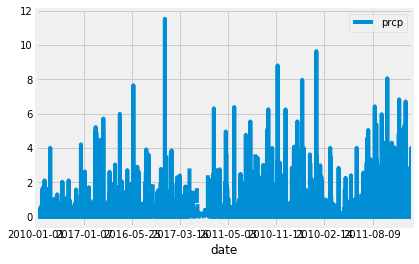

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurements_data = session.query(Measurement.date, Measurement.prcp)

df = pd.DataFrame(measurements_data.all(), columns=['date', 'prcp'])

df.set_index(['date'], inplace=True)
df.plot()


# Calculate the date 1 year ago from the last data point in the database
x = measurements_data.order_by(desc(Measurement.date)).limit(1)
date_last_data_point = x[0].date
date_1year_ago_data_point = dt.datetime.strptime(date_last_data_point, '%Y-%m-%d')  - dt.timedelta(days=1*365)
date_1year_ago_data_point = date_1year_ago_data_point.strftime('%Y-%m-%d')
t = session.query(Measurement).filter(Measurement.date==date_1year_ago_data_point)

for c in t:
    print(c.station, c.date, c.prcp, c.tobs)
    

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(df.describe())

               prcp
count  18103.000000
mean       0.160644
std        0.468746
min        0.000000
25%        0.000000
50%        0.010000
75%        0.110000
max       11.530000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Station).count()
print(station_count)


9


In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_freq = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

for x in station_freq:
    print(x)



('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

station_average_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for x in station_freq:
    print(x)
    
print("----------------------")    

station_min_temp = session.query(Measurement.station, func.min(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for x in station_min_temp:
    print(x)
print("----------------------")    
    
station_max_temp = session.query(Measurement.station, func.max(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for x in station_max_temp:
    print(x)
print("----------------------")    


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
----------------------
('USC00519281', 54.0)
('USC00519397', 56.0)
('USC00513117', 59.0)
('USC00519523', 56.0)
('USC00516128', 58.0)
('USC00514830', 58.0)
('USC00511918', 53.0)
('USC00517948', 58.0)
('USC00518838', 58.0)
----------------------
('USC00519281', 85.0)
('USC00519397', 87.0)
('USC00513117', 85.0)
('USC00519523', 85.0)
('USC00516128', 84.0)
('USC00514830', 85.0)
('USC00511918', 87.0)
('USC00517948', 87.0)
('USC00518838', 83.0)
----------------------


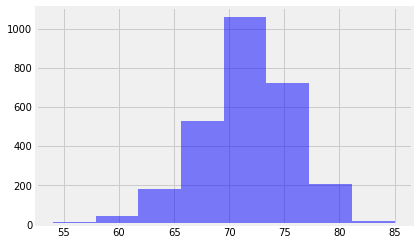

In [66]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_freq = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
station_highest_tobs = station_freq[0]
v = session.query(Measurement.tobs).filter(Measurement.station == station_highest_tobs).group_by(Measurement.date).order_by(Measurement.date).all()


result = [r[0]for r in v]

num_bins=5
n, bins, patches = plt.hist(result, 8, facecolor='blue', alpha=0.5)
plt.show()

![precipitation](Images/station-histogram.png)

In [67]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [68]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))



[(61.0, 69.75510204081633, 75.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


plt.title("Trip Avg Temp")

plt.show()

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
